In [111]:
import numpy as np
import pandas as pd
import os, sys
from pathlib import Path
from hist import intervals

sys.path.append("/users/hep/eigen1907/Workspace/Workspace-RPC/modules")
from NanoAODTnP.Plotting.DataLoader import DataLoader
from NanoAODTnP.Plotting.Hist1D import init_figure

In [112]:
workspace = Path('/users/hep/eigen1907/Workspace/Workspace-RPC')

input_2022_path = workspace / 'data' / 'efficiency' / 'data' / 'Run2022.root'
roll_blacklist_2022_path = workspace / 'data' / 'efficiency' / 'blacklist' / 'roll-blacklist-2022.json'

input_2023_path = workspace / 'data' / 'efficiency' / 'data' / 'Run2023.root'
roll_blacklist_2023_path = workspace / 'data' / 'efficiency' / 'blacklist' / 'roll-blacklist-2023.json'

geom_path = workspace / 'data' / 'efficiency' / 'geometry' / 'run3.csv'

run_info = pd.read_csv("/users/hep/eigen1907/Workspace/Workspace-RPC/data/efficiency/run_info/run_info.csv", index_col=False)

data_2022 = DataLoader(
    input_path = input_2022_path,
    geom_path = geom_path,
    roll_blacklist_path = roll_blacklist_2022_path,
    var = ['run']
)

data_2022 = data_2022.filter_data(keys = ['is_fiducial', 'is_linked'])

barrel_data_2022 = data_2022.filter_data(region = 'Barrel')
endcap_data_2022 = data_2022.filter_data(region = 'Endcap')

data_2023 = DataLoader(
    input_path = input_2023_path,
    geom_path = geom_path,
    roll_blacklist_path = roll_blacklist_2023_path,
    var = ['run']
)

data_2023 = data_2023.filter_data(keys = ['is_fiducial', 'is_linked'])

barrel_data_2023 = data_2023.filter_data(region = 'Barrel')
endcap_data_2023 = data_2023.filter_data(region = 'Endcap')

/users/hep/eigen1907/micromamba/envs/ds4hep/lib/python3.11/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/users/hep/eigen1907/micromamba/envs/ds4hep/lib/python3.11/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from hist import intervals
from datetime import datetime

def run2time(run, run_info):
    time = None
    while True:
        if time is not None: break
        if round(run) in run_info['run_number'].values:
            time = run_info['start_time'][run_info['run_number'] == round(run)].values[0]
            time = datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
        run += 1
    return time

def plot_eff_run(ax, data):
    tree = data.tree 
    runs = np.unique(tree['run'])
    effs, err_uppers, err_lowers = [], [], []
    for run in runs:
        run_mask = (tree['run'] == run)

        total = tree['is_matched'][run_mask]
        passed = total[total]
        
        eff = len(passed) / len(total) * 100
        err = intervals.clopper_pearson_interval(len(passed), len(total), 0.68) * 100
        
        effs.append(eff)
        err_lowers.append(eff - err[0])
        err_uppers.append(err[1] - eff)

    ax.errorbar(
        runs,
        effs,
        yerr = (err_lowers, err_uppers),
        fmt = 's',
        markersize = 7,
        capsize = 5,
        color = data.facecolors[1],
        label = data.region,
    )
    return ax, effs, runs

def plot_eff_time(ax, data, run_info):
    tree = data.tree 
    runs = np.unique(tree['run'])
    times = []
    effs, err_uppers, err_lowers = [], [], []
    for run in runs:
        times.append(run2time(run, run_info))
        run_mask = (tree['run'] == run)

        total = tree['is_matched'][run_mask]
        passed = total[total]
        
        eff = len(passed) / len(total) * 100
        err = intervals.clopper_pearson_interval(len(passed), len(total), 0.68) * 100
        
        effs.append(eff)
        err_lowers.append(eff - err[0])
        err_uppers.append(err[1] - eff)

    ax.errorbar(
        times,
        effs,
        yerr = (err_lowers, err_uppers),
        fmt = 's',
        markersize = 7,
        capsize = 5,
        color = data.facecolors[1],
        label = data.region,
        alpha = 0.7
    )
    return ax, effs, runs

def plot_eff_time_region_2022(region_data_2022, run_info, output_dir):
    # Initialize the figure (assuming init_figure is a predefined function)
    fig, ax = init_figure(
        figsize=(20, 9),
        fontsize=24,
        com=13.6,
        label1='Work in Progress',
        label2=f'{region_data_2022.region} Efficiency 2022',
        loc=0,
        xlabel='Date/Month',
        ylabel='Efficiency [%]',
        xlim=None,
        ylim=None,
        xticks=None,
        yticks=None,
        log_scale=False,
    )
    
    # Set y-axis limits
    ax.set_ylim(0, 100)
    
    # Set x-axis limits (assuming run2time and run_info are predefined)
    ax.set_xlim(run2time(355100, run_info), run2time(362760, run_info))
    
    # Plot efficiency data (assuming plot_eff_time is a predefined function)
    tree = region_data_2022.tree 
    runs = np.unique(tree['run'])
    times = []
    effs = []
    for run in runs:
        times.append(run2time(run, run_info))
        run_mask = (tree['run'] == run)

        total = tree['is_matched'][run_mask]
        passed = total[total]
        
        eff = len(passed) / len(total) * 100     
        effs.append(eff)

    ax.scatter(
        times,
        effs,
        marker = 's',
        s = 50,
        color = region_data_2022.facecolors[1],
        #label = region_data_2022.region,
        alpha = 0.7
    )
    
    # Add colored spans with annotations
    spans = [
        (355100, 355769, 'Run2022B', 'y'),
        (355862, 357482, 'Run2022C', 'm'),
        (357538, 357900, 'Run2022D', 'y'),
        (359356, 360327, 'Run2022E', 'm'),
        (360335, 362167, 'Run2022F', 'y'),
        (362362, 362760, 'Run2022G', 'm'),
    ]
    
    for start, end, label, color in spans:
        ax.axvspan(run2time(start, run_info), run2time(end, run_info), color=color, alpha=0.05)
        mid_point = run2time((start + end) // 2, run_info)
        ax.text(mid_point, 20, label, rotation=90, verticalalignment='center', fontsize=22, weight='bold', color=color)
    
    # Add additional lines
    ax.plot([run2time(355100, run_info), run2time(362760, run_info)], [80, 80], color = 'gray', lw = 2, linestyle = '--')
    ax.plot([run2time(355100, run_info), run2time(362760, run_info)], [90, 90], color = 'gray', lw = 2, linestyle = '--')
    
    # Set x-axis major ticks to be on the 1st and 15th of each month and format the ticks to display day/month
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=(1, 15)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    
    # Tilt x-axis tick labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
    
    # Adjust layout to make space for labels
    plt.tight_layout(rect=[0, 0, 1, 1])  # Optionally, you can fine-tune this
    
    # Add legend
    #ax.legend(loc='center right', fontsize = 24)
    
    # Save the figure
    if not output_dir.exists():
        output_dir.mkdir(parents=True)
    
    fig.savefig(output_dir / f"{region_data_2022.region}.png")


def plot_eff_time_region_2023(region_data_2023, run_info, output_dir):
    # Initialize the figure (assuming init_figure is a predefined function)
    fig, ax = init_figure(
        figsize=(20, 9),
        fontsize=24,
        com=13.6,
        label1='Work in Progress',
        label2=f'{region_data_2023.region} Efficiency 2023',
        loc=0,
        xlabel='Date/Month',
        ylabel='Efficiency [%]',
        xlim=None,
        ylim=None,
        xticks=None,
        yticks=None,
        log_scale=False,
    )

    # Set y-axis limits
    ax.set_ylim(0, 100)

    # Set x-axis limits (assuming run2time and run_info are predefined)
    ax.set_xlim(run2time(366403, run_info), run2time(371225, run_info))

    # Plot efficiency data (assuming plot_eff_time is a predefined function)
    tree = region_data_2023.tree 
    runs = np.unique(tree['run'])
    times = []
    effs = []
    for run in runs:
        times.append(run2time(run, run_info))
        run_mask = (tree['run'] == run)

        total = tree['is_matched'][run_mask]
        passed = total[total]
        
        eff = len(passed) / len(total) * 100     
        effs.append(eff)

    ax.scatter(
        times,
        effs,
        marker = 's',
        s = 50,
        color = region_data_2023.facecolors[1],
        #label = region_data_2022.region,
        alpha = 0.7
    )

    # Add colored spans with annotations
    spans = [
        (366403, 367079, 'Run2023B', 'y'),
        (367770, 369694, 'Run2023C', 'm'),
        (370616, 371225, 'Run2023D', 'y'),
    ]

    for start, end, label, color in spans:
        ax.axvspan(run2time(start, run_info), run2time(end, run_info), color=color, alpha=0.05)
        mid_point = run2time((start + end) // 2, run_info)
        ax.text(mid_point, 20, label, rotation=90, verticalalignment='center', fontsize=22, weight='bold', color=color)

    # Add additional lines
    ax.plot([run2time(366403, run_info), run2time(371225, run_info)], [80, 80], color = 'gray', lw = 2, linestyle = '--')
    ax.plot([run2time(366403, run_info), run2time(371225, run_info)], [90, 90], color = 'gray', lw = 2, linestyle = '--')

    # Set x-axis major ticks to be on the 1st and 15th of each month and format the ticks to display day/month
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=(1, 15)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))

    # Tilt x-axis tick labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # Adjust layout to make space for labels
    plt.tight_layout(rect=[0, 0, 1, 1])  # Optionally, you can fine-tune this

    # Add legend
    #ax.legend(loc='center right', fontsize = 24)

    # Save the figure
    if not output_dir.exists():
        output_dir.mkdir(parents=True)

    fig.savefig(output_dir / f"{region_data_2023.region}.png")

In [ ]:
output_dir = Path("/users/hep/eigen1907/Workspace/Workspace-RPC/240425-TnP_RPC24/Plotting/Scatter-run-eff/with_blacklist_time_2022")
#plot_eff_time_region_2022(data_2022, run_info, output_dir)

eff_2022 = np.divide(
    data_2022.passed, data_2022.total,
    out = np.zeros_like(data_2022.total),
    where = (data_2022.total > 0)
) * 100

roll_names_2022 = data_2022.roll_names

roll_names_2022_eff_40_70 = roll_names_2022[(eff_2022 > 40) & (eff_2022 <= 70)]
roll_names_2022_eff_under_40 = roll_names_2022[eff_2022 <= 40]

for roll_name in roll_names_2022_eff_40_70:
    roll_data_2022 = data_2022.filter_data(region = roll_name)
    plot_eff_time_region_2022(roll_data_2022, run_info, output_dir / 'eff_40_70')

for roll_name in roll_names_2022_eff_under_40:
    roll_data_2022 = data_2022.filter_data(region = roll_name)
    plot_eff_time_region_2022(roll_data_2022, run_info, output_dir / 'eff_under_40')


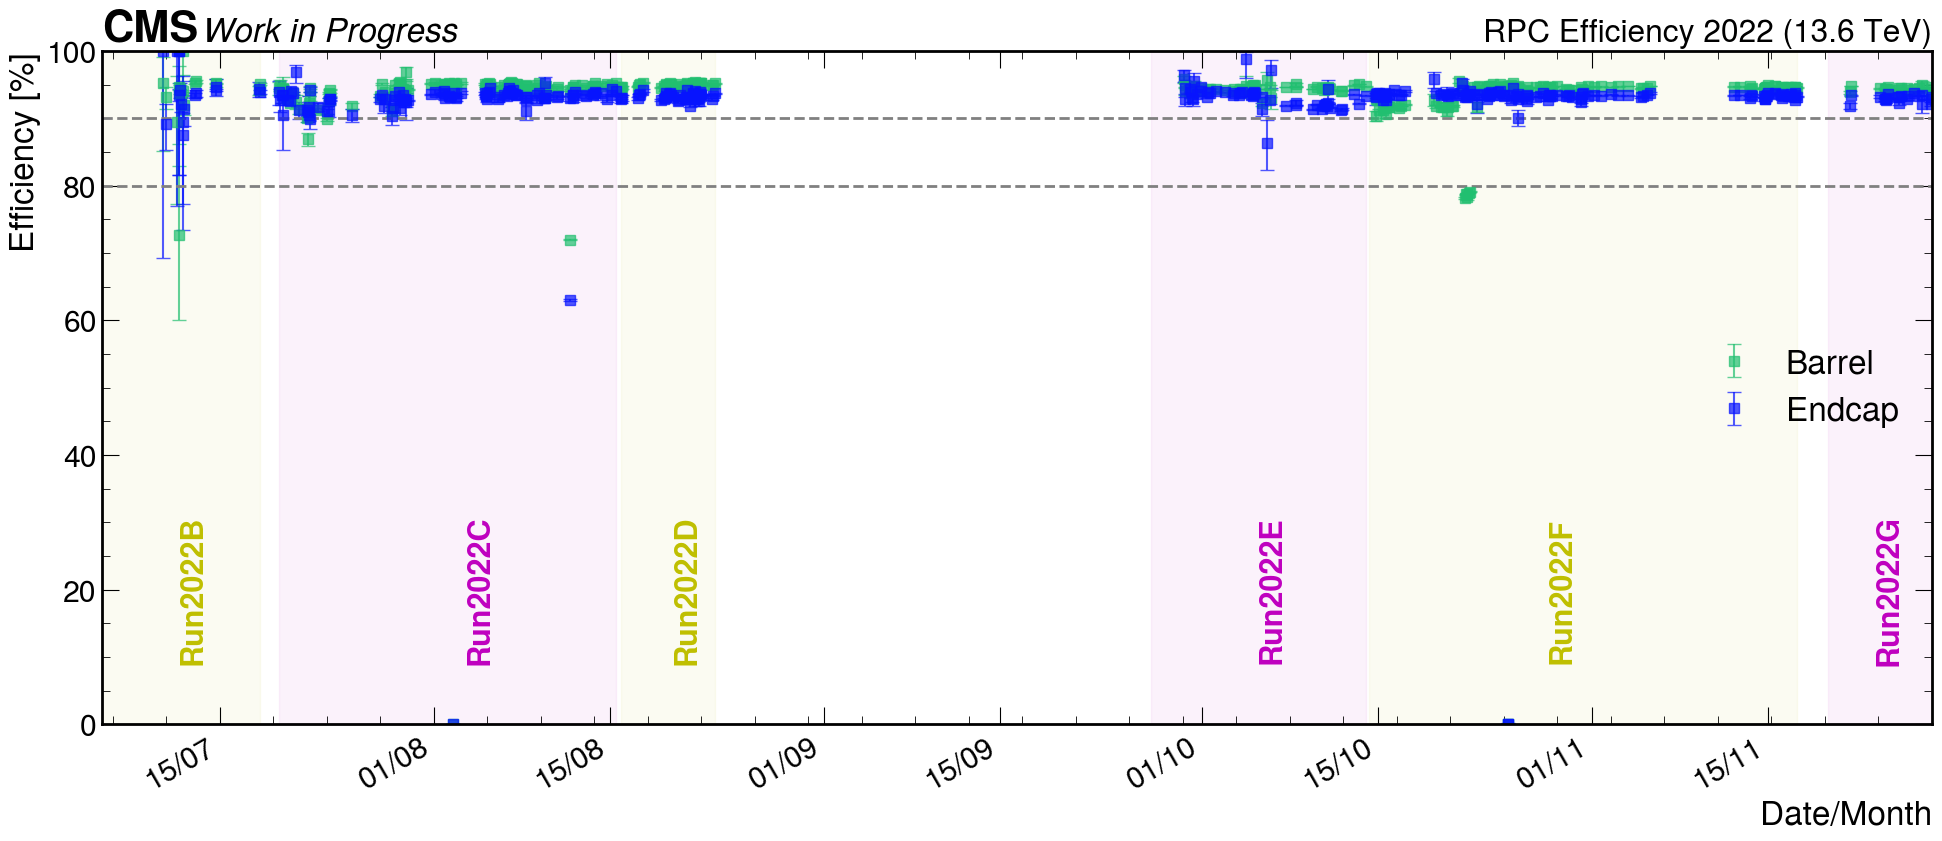

In [100]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from pathlib import Path

# Initialize the figure (assuming init_figure is a predefined function)
fig, ax = init_figure(
    figsize=(20, 9),
    fontsize=24,
    com=13.6,
    label1='Work in Progress',
    label2=f'RPC Efficiency 2022',
    loc=0,
    xlabel='Date/Month',
    ylabel='Efficiency [%]',
    xlim=None,
    ylim=None,
    xticks=None,
    yticks=None,
    log_scale=False,
)

# Set y-axis limits
ax.set_ylim(0, 100)

# Set x-axis limits (assuming run2time and run_info are predefined)
ax.set_xlim(run2time(355100, run_info), run2time(362760, run_info))

# Plot efficiency data (assuming plot_eff_time is a predefined function)
ax, barrel_effs_2022, runs_2022 = plot_eff_time(ax, barrel_data_2022, run_info)
ax, endcap_effs_2022, runs_2022 = plot_eff_time(ax, endcap_data_2022, run_info)

# Add colored spans with annotations
spans = [
    (355100, 355769, 'Run2022B', 'y'),
    (355862, 357482, 'Run2022C', 'm'),
    (357538, 357900, 'Run2022D', 'y'),
    (359356, 360327, 'Run2022E', 'm'),
    (360335, 362167, 'Run2022F', 'y'),
    (362362, 362760, 'Run2022G', 'm'),
]

for start, end, label, color in spans:
    ax.axvspan(run2time(start, run_info), run2time(end, run_info), color=color, alpha=0.05)
    mid_point = run2time((start + end) // 2, run_info)
    ax.text(mid_point, 20, label, rotation=90, verticalalignment='center', fontsize=22, weight='bold', color=color)

# Add additional lines
ax.plot([run2time(355100, run_info), run2time(362760, run_info)], [80, 80], color = 'gray', lw = 2, linestyle = '--')
ax.plot([run2time(355100, run_info), run2time(362760, run_info)], [90, 90], color = 'gray', lw = 2, linestyle = '--')

# Set x-axis major ticks to be on the 1st and 15th of each month and format the ticks to display day/month
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=(1, 15)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))

# Tilt x-axis tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# Adjust layout to make space for labels
plt.tight_layout(rect=[0, 0, 1, 1])  # Optionally, you can fine-tune this

# Add legend
ax.legend(loc='center right', fontsize = 24)

# Save the figure
output_dir = Path('/users/hep/eigen1907/Workspace/Workspace-RPC/240425-TnP_RPC24/Plotting/Scatter-run-eff')

if not output_dir.exists():
    output_dir.mkdir(parents=True)

fig.savefig(output_dir / "with_blacklist_time_2022.png")

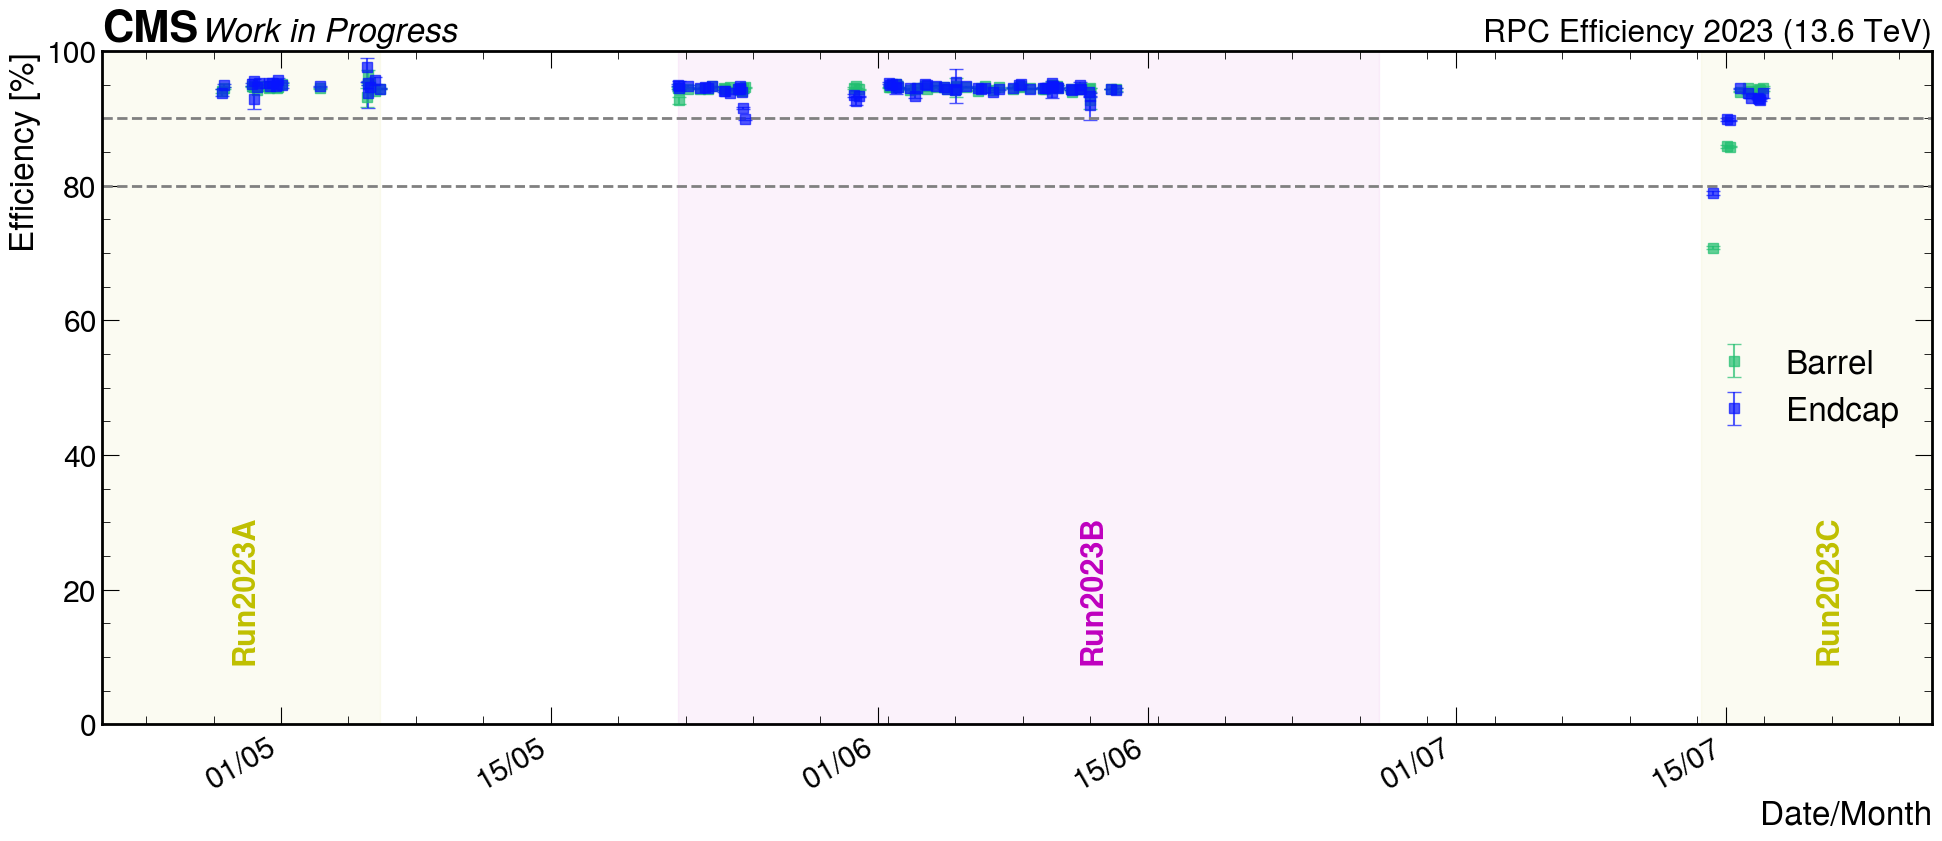

In [101]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from pathlib import Path

# Initialize the figure (assuming init_figure is a predefined function)
fig, ax = init_figure(
    figsize=(20, 9),
    fontsize=24,
    com=13.6,
    label1='Work in Progress',
    label2=f'RPC Efficiency 2023',
    loc=0,
    xlabel='Date/Month',
    ylabel='Efficiency [%]',
    xlim=None,
    ylim=None,
    xticks=None,
    yticks=None,
    log_scale=False,
)

# Set y-axis limits
ax.set_ylim(0, 100)

# Set x-axis limits (assuming run2time and run_info are predefined)
ax.set_xlim(run2time(366403, run_info), run2time(371225, run_info))

# Plot efficiency data (assuming plot_eff_time is a predefined function)
ax, barrel_effs_2023, runs_2023 = plot_eff_time(ax, barrel_data_2023, run_info)
ax, endcap_effs_2023, runs_2023 = plot_eff_time(ax, endcap_data_2023, run_info)

# Add colored spans with annotations
spans = [
    (366403, 367079, 'Run2023A', 'y'),
    (367770, 369694, 'Run2023B', 'm'),
    (370616, 371225, 'Run2023C', 'y'),
]

for start, end, label, color in spans:
    ax.axvspan(run2time(start, run_info), run2time(end, run_info), color=color, alpha=0.05)
    mid_point = run2time((start + end) // 2, run_info)
    ax.text(mid_point, 20, label, rotation=90, verticalalignment='center', fontsize=22, weight='bold', color=color)

# Add additional lines
ax.plot([run2time(366403, run_info), run2time(371225, run_info)], [80, 80], color = 'gray', lw = 2, linestyle = '--')
ax.plot([run2time(366403, run_info), run2time(371225, run_info)], [90, 90], color = 'gray', lw = 2, linestyle = '--')

# Set x-axis major ticks to be on the 1st and 15th of each month and format the ticks to display day/month
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=(1, 15)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))

# Tilt x-axis tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# Adjust layout to make space for labels
plt.tight_layout(rect=[0, 0, 1, 1])  # Optionally, you can fine-tune this

# Add legend
ax.legend(loc='center right', fontsize = 24)

# Save the figure
output_dir = Path('/users/hep/eigen1907/Workspace/Workspace-RPC/240425-TnP_RPC24/Plotting/Scatter-run-eff')

if not output_dir.exists():
    output_dir.mkdir(parents=True)

fig.savefig(output_dir / "with_blacklist_time_2023.png")

In [97]:
barrel_effs_2022 = np.array(barrel_effs_2022)
endcap_effs_2022 = np.array(endcap_effs_2022)
runs_2022 = np.array(runs_2022)

# Extracting runs based on conditions
barrel_less_80_2022 = runs_2022[barrel_effs_2022 < 80]
endcap_less_80_2022 = runs_2022[endcap_effs_2022 < 80]

barrel_80_90_2022 = runs_2022[(barrel_effs_2022 < 90) & (barrel_effs_2022 >= 80)]
endcap_80_90_2022 = runs_2022[(endcap_effs_2022 < 90) & (endcap_effs_2022 >= 80)]

# Combining all runs into one set
all_runs_2022 = set(barrel_less_80_2022) | set(endcap_less_80_2022) | set(barrel_80_90_2022) | set(endcap_80_90_2022)

# Converting the set back to a list
all_runs_2022 = np.sort(list(all_runs_2022))

print(all_runs_2022)

[355381 355429 355442 355454 355455 355989 356004 356071 356580 357329
 359887 360887 360888 360889 360890 360892 360895 361050 361052]


In [88]:
barrel_effs_2023 = np.array(barrel_effs_2023)
endcap_effs_2023 = np.array(endcap_effs_2023)
runs_2023 = np.array(runs_2023)

# Extracting runs based on conditions
barrel_less_80_2023 = runs_2023[barrel_effs_2023 < 80]
endcap_less_80_2023 = runs_2023[endcap_effs_2023 < 80]

barrel_80_90_2023 = runs_2023[(barrel_effs_2023 < 90) & (barrel_effs_2023 >= 80)]
endcap_80_90_2023 = runs_2023[(endcap_effs_2023 < 90) & (endcap_effs_2023 >= 80)]

# Combining all runs into one set
all_runs_2023 = set(barrel_less_80_2023) | set(endcap_less_80_2023) | set(barrel_80_90_2023) | set(endcap_80_90_2023)

# Converting the set back to a list
all_runs_2023 = np.sort(list(all_runs_2023))

In [96]:
all_runs_underflow = np.append(all_runs_2022, all_runs_2023)
print(all_runs_underflow)

is_underflow = np.vectorize(lambda item: item in all_runs_underflow)

runs = np.append(runs_2022, runs_2023)
barrel_effs = np.append(barrel_effs_2022, barrel_effs_2023)
endcap_effs = np.append(endcap_effs_2022, endcap_effs_2023)

table = {
    'Run Number': runs[is_underflow(runs)],
    'Efficinecy(Barrel)': barrel_effs[is_underflow(runs)],
    'Efficiency(Endcap)': endcap_effs[is_underflow(runs)]
}

df_table = pd.DataFrame(table)

df_table = df_table.round(2)

df_table.to_csv('/users/hep/eigen1907/Workspace/Workspace-RPC/240425-TnP_RPC24/Plotting/Scatter-run-eff/underflow_efficiency_table.csv', index=False)

print("CSV file saved successfully.")

[355381 355429 355442 355454 355455 355989 356004 356071 356580 357329
 359887 360887 360888 360889 360890 360892 360895 361050 361052 367910
 370667 370717 370725]
CSV file saved successfully.


In [110]:
print(all_runs_underflow)

for run in all_runs_underflow:
    print(f'Run:{run}, {run2time(run, run_info)}')

#print(run2time(all_runs_underflow, run_info))

[355381 355429 355442 355454 355455 355989 356004 356071 356580 357329
 359887 360887 360888 360889 360890 360892 360895 361050 361052 367910
 370667 370717 370725]
Run:355381, 2022-07-10 16:10:23
Run:355429, 2022-07-11 14:26:27
Run:355442, 2022-07-11 18:13:24
Run:355454, 2022-07-12 01:20:23
Run:355455, 2022-07-12 02:11:18
Run:355989, 2022-07-21 23:23:03
Run:356004, 2022-07-22 04:03:35
Run:356071, 2022-07-23 12:28:35
Run:356580, 2022-08-02 12:20:46
Run:357329, 2022-08-11 20:12:25
Run:359887, 2022-10-06 04:56:20
Run:360887, 2022-10-21 22:33:15
Run:360888, 2022-10-21 23:28:37
Run:360889, 2022-10-22 01:26:49
Run:360890, 2022-10-22 01:43:23
Run:360892, 2022-10-22 05:12:50
Run:360895, 2022-10-22 07:34:18
Run:361050, 2022-10-25 07:24:53
Run:361052, 2022-10-25 07:34:35
Run:367910, 2023-05-25 01:44:15
Run:370667, 2023-07-14 08:10:36
Run:370717, 2023-07-15 00:55:47
Run:370725, 2023-07-15 04:57:09
